# Notebook 4 — Flood Seasonality Analysis :   “"When during the year does it peak?”

In [ ]:
# Basic packages
import pandas as pd
import numpy as np

# Modeling
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Style
sns.set(style="whitegrid")
pd.set_option("display.max_columns", None)


Load & Format the Monthly Discharge Files

In [ ]:
import zipfile
import os

# Path to your uploaded zip
zip_path = "/content/ADHI_MonthlySeries.zip"
extract_dir = "/content/ADHI/ADHI_MonthlySeries"

# Make sure the target folder exists
os.makedirs(extract_dir, exist_ok=True)

# Unzip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Unzipped to:", extract_dir)


Unzipped to: /content/ADHI/ADHI_MonthlySeries


In [ ]:
import os
import pandas as pd
import glob

# Path to your directory
monthly_dir = "/content/ADHI/ADHI_MonthlySeries/MonthlySeries"

# Get all .txt files
monthly_files = glob.glob(os.path.join(monthly_dir, "*.txt"))

print(f"Found {len(monthly_files)} monthly files.")

Found 1466 monthly files.


In [ ]:

# Load all files into a single DataFrame
monthly_data = []

for file in monthly_files:
    station_id = os.path.basename(file).split("_")[-1].replace(".txt", "")

    df = pd.read_csv(file, header=None, names=["Year", "Month", "Mean_Q", "Max_Q", "Min_Q", "Missing_days"])
    df["Station_ID"] = f"ADHI_{station_id}"

    monthly_data.append(df)

# Concatenate all into a single DataFrame
monthly_df = pd.concat(monthly_data, ignore_index=True)
print("Combined monthly data shape:", monthly_df.shape)
monthly_df.head()


Combined monthly data shape: (1213848, 7)


,Year,Month,Mean_Q,Max_Q,Min_Q,Missing_days,Station_ID
0,1950,1,NaN,NaN,NaN,31,ADHI_594
1,1950,2,NaN,NaN,NaN,28,ADHI_594
2,1950,3,NaN,NaN,NaN,31,ADHI_594
3,1950,4,NaN,NaN,NaN,30,ADHI_594
4,1950,5,NaN,NaN,NaN,31,ADHI_594


Preprocess & Clean the Data

In [ ]:
# Drop rows where all Q values are NaN
monthly_df = monthly_df.dropna(subset=["Mean_Q", "Max_Q", "Min_Q"], how="all")

# Create a datetime column
monthly_df["Date"] = pd.to_datetime(dict(year=monthly_df["Year"], month=monthly_df["Month"], day=1))

# Sort the data
monthly_df = monthly_df.sort_values(by=["Station_ID", "Date"]).reset_index(drop=True)

# Preview
print("Cleaned data shape:", monthly_df.shape)
monthly_df.head()


Cleaned data shape: (510762, 8)


,Year,Month,Mean_Q,Max_Q,Min_Q,Missing_days,Station_ID,Date
0,1963,5,10.31,16.29,5.46,7,ADHI_1,1963-05-01
1,1963,6,18.98,33.29,7.46,0,ADHI_1,1963-06-01
2,1963,7,20.55,27.60,14.69,0,ADHI_1,1963-07-01
3,1963,8,56.82,101.00,22.00,0,ADHI_1,1963-08-01
4,1963,9,57.00,96.30,39.90,0,ADHI_1,1963-09-01


In [ ]:
stations_df = pd.read_csv("ADHI_stations.csv")
# Step 1: Extract relevant columns
station_country_df = stations_df[["ID", "Country"]].copy()

# Step 2: Rename for consistency with ADHI summary table
station_country_df = station_country_df.rename(columns={"ID": "ADHI_ID"})

# Step 3: Save to CSV
station_country_df.to_csv("stations_by_country.csv", index=False)

# Preview
print("Saved stations_by_country.csv with the following columns:")
display(station_country_df.head())

Saved stations_by_country.csv with the following columns:


,ADHI_ID,Country
0,ADHI_1,Cameroon
1,ADHI_2,Cameroon
2,ADHI_3,Cameroon
3,ADHI_4,Cameroon
4,ADHI_5,Cameroon


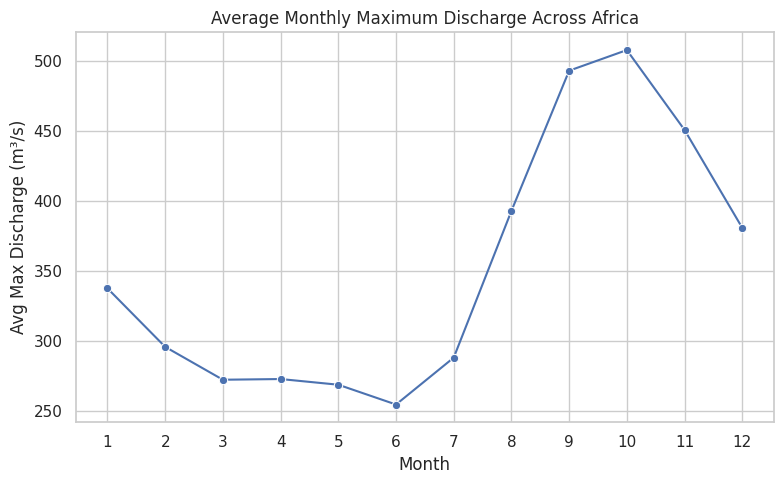

In [ ]:
# Group across all stations: average monthly Max_Q
global_monthly = monthly_df.groupby("Month")["Max_Q"].mean().reset_index()

plt.figure(figsize=(8, 5))
sns.lineplot(data=global_monthly, x="Month", y="Max_Q", marker="o")
plt.title("Average Monthly Maximum Discharge Across Africa")
plt.xlabel("Month")
plt.ylabel("Avg Max Discharge (m³/s)")
plt.xticks(range(1, 13))
plt.grid(True)
plt.tight_layout()
plt.show()


 Visualize Seasonality by Station

<ipython-input-62-94a3691f687f>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=station_monthly, x="Month", y="Max_Q", palette="Blues_d")


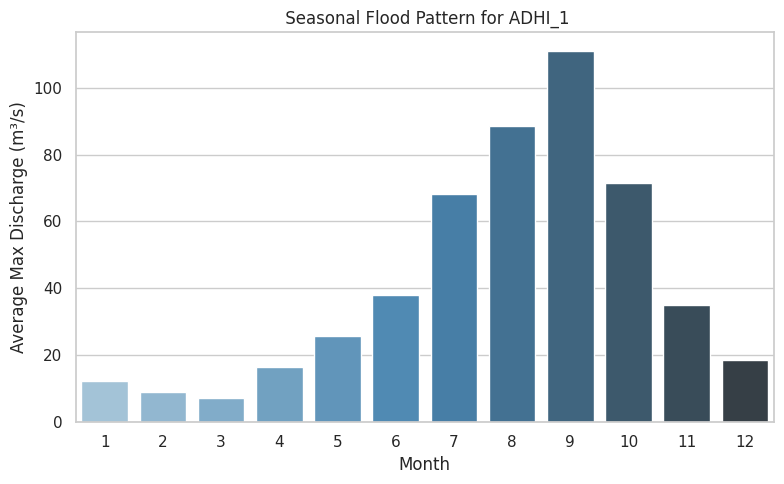

In [ ]:
# Choose a station
station_id = "ADHI_1"  # replace as needed

# Group by month for that station
station_monthly = (
    monthly_df[monthly_df["Station_ID"] == station_id]
    .groupby("Month")["Max_Q"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(8, 5))
sns.barplot(data=station_monthly, x="Month", y="Max_Q", palette="Blues_d")
plt.title(f" Seasonal Flood Pattern for {station_id}")
plt.xlabel("Month")
plt.ylabel("Average Max Discharge (m³/s)")
plt.tight_layout()
plt.show()


 Visualize Seasonality by Country

In [ ]:
# Rename for consistency
station_country_df = station_country_df.rename(columns={"ADHI_ID": "Station_ID"})

# Merge into monthly_df
monthly_df = monthly_df.merge(station_country_df, on="Station_ID", how="left")

# Preview to verify merge
monthly_df.drop_duplicates().head()


,Year,Month,Mean_Q,Max_Q,Min_Q,Missing_days,Station_ID,Date,Country_x,YearMonth,season_label,Country_y
0,1963,5,10.31,16.29,5.46,7,ADHI_1,1963-05-01,Cameroon,1963-05,Pre-Flood,Cameroon
1,1963,6,18.98,33.29,7.46,0,ADHI_1,1963-06-01,Cameroon,1963-06,Flood_Season,Cameroon
2,1963,7,20.55,27.60,14.69,0,ADHI_1,1963-07-01,Cameroon,1963-07,Flood_Season,Cameroon
3,1963,8,56.82,101.00,22.00,0,ADHI_1,1963-08-01,Cameroon,1963-08,Flood_Season,Cameroon
4,1963,9,57.00,96.30,39.90,0,ADHI_1,1963-09-01,Cameroon,1963-09,Flood_Season,Cameroon


In [ ]:
monthly_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510762 entries, 0 to 510761
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Year          510762 non-null  int32         
 1   Month         510762 non-null  int64         
 2   Mean_Q        510762 non-null  float64       
 3   Max_Q         510762 non-null  float64       
 4   Min_Q         510762 non-null  float64       
 5   Missing_days  510762 non-null  int64         
 6   Station_ID    510762 non-null  object        
 7   Date          510762 non-null  datetime64[ns]
 8   Country_x     510762 non-null  object        
 9   YearMonth     510762 non-null  period[M]     
 10  season_label  510762 non-null  object        
 11  Country_y     510762 non-null  object        
dtypes: datetime64[ns](1), float64(3), int32(1), int64(2), object(4), period[M](1)
memory usage: 44.8+ MB


<ipython-input-66-9fea098629ca>:21: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


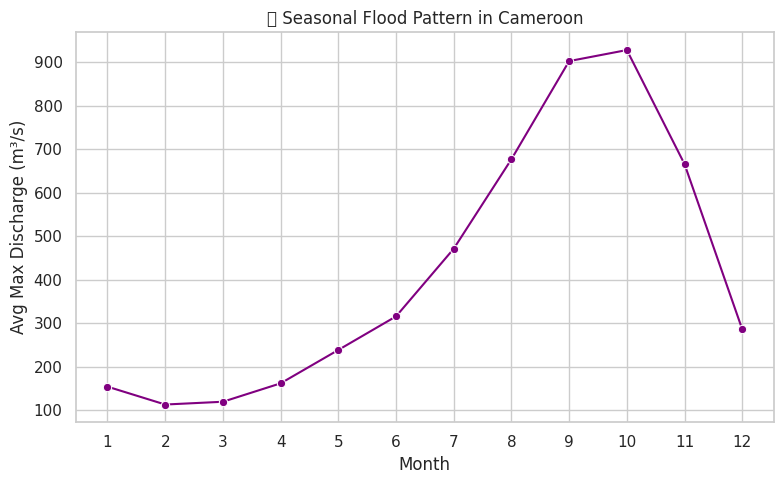

In [ ]:
# Pick a country
country_name = "Cameroon"
monthly_df = monthly_df.rename(columns={"Country_x": "Country"})

# Compute average monthly Max_Q for this country
country_monthly = (
    monthly_df[monthly_df["Country"] == country_name]
    .groupby("Month")["Max_Q"]
    .mean()
    .reset_index()
)

# Plot
plt.figure(figsize=(8, 5))
sns.lineplot(data=country_monthly, x="Month", y="Max_Q", marker="o", color="purple")
plt.title(f"📊 Seasonal Flood Pattern in {country_name}")
plt.xlabel("Month")
plt.ylabel("Avg Max Discharge (m³/s)")
plt.xticks(range(1, 13))
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Group by Country & Month and compute average Max_Q
seasonal_country = (
    monthly_df.groupby(["Country", "Month"])["Max_Q"]
    .mean()
    .reset_index()
)

# Pivot into Country × Month matrix
seasonality_pivot = seasonal_country.pivot(index="Country", columns="Month", values="Max_Q")

# Sort by peak month (optional)
seasonality_pivot = seasonality_pivot.sort_values(by=seasonality_pivot.columns.tolist(), ascending=False)


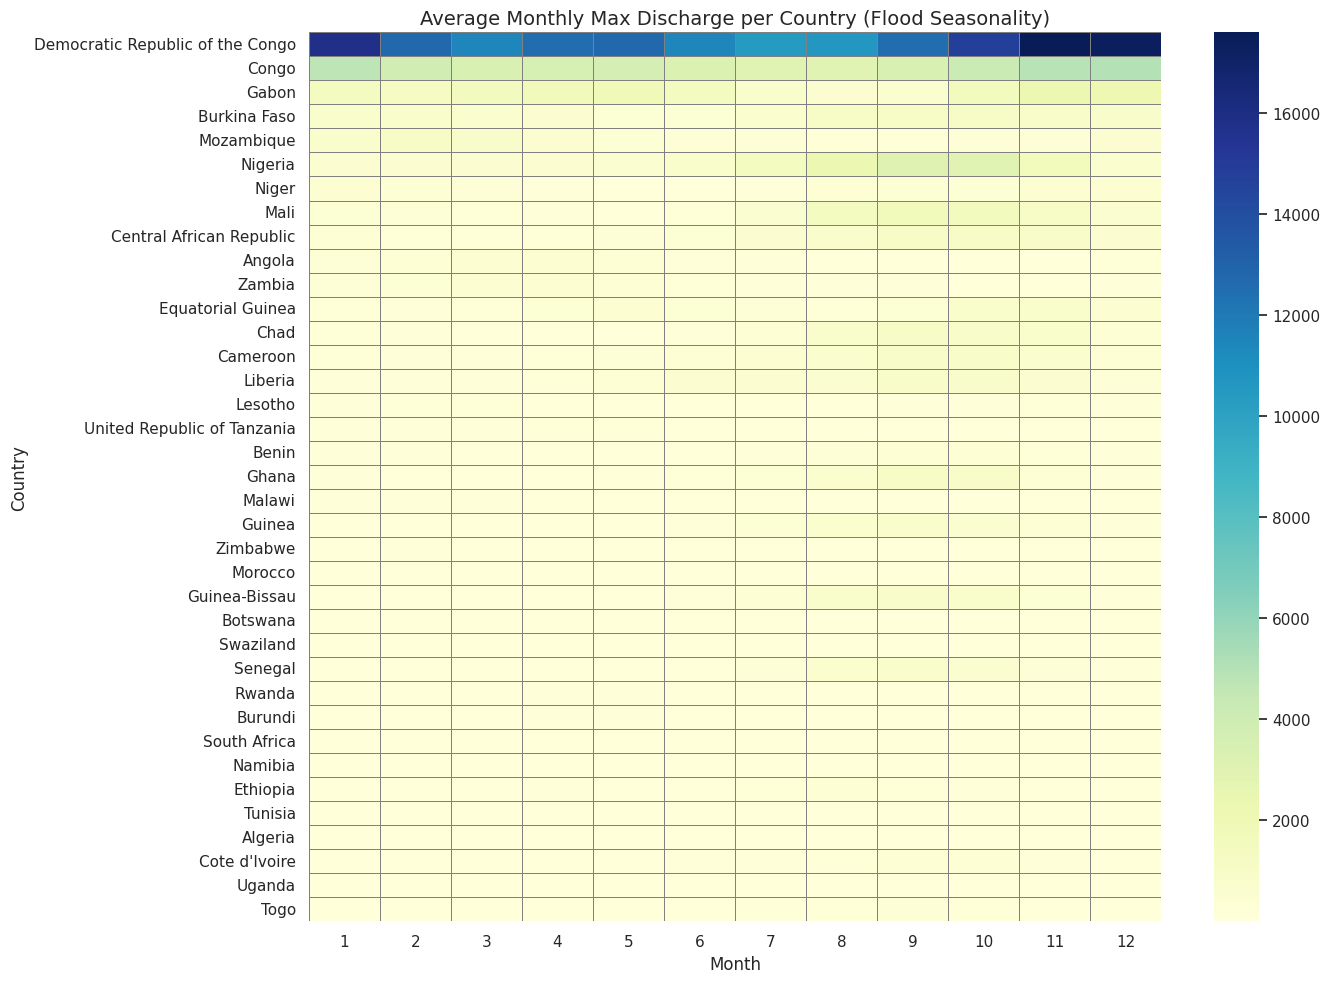

In [ ]:
plt.figure(figsize=(14, 10))
sns.heatmap(seasonality_pivot, cmap="YlGnBu", linewidths=0.5, linecolor="gray", annot=False)

plt.title("Average Monthly Max Discharge per Country (Flood Seasonality)", fontsize=14)
plt.xlabel("Month")
plt.ylabel("Country")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


Log Normalize the Discharge : continent-wide fingerprint of monthly flood behavior

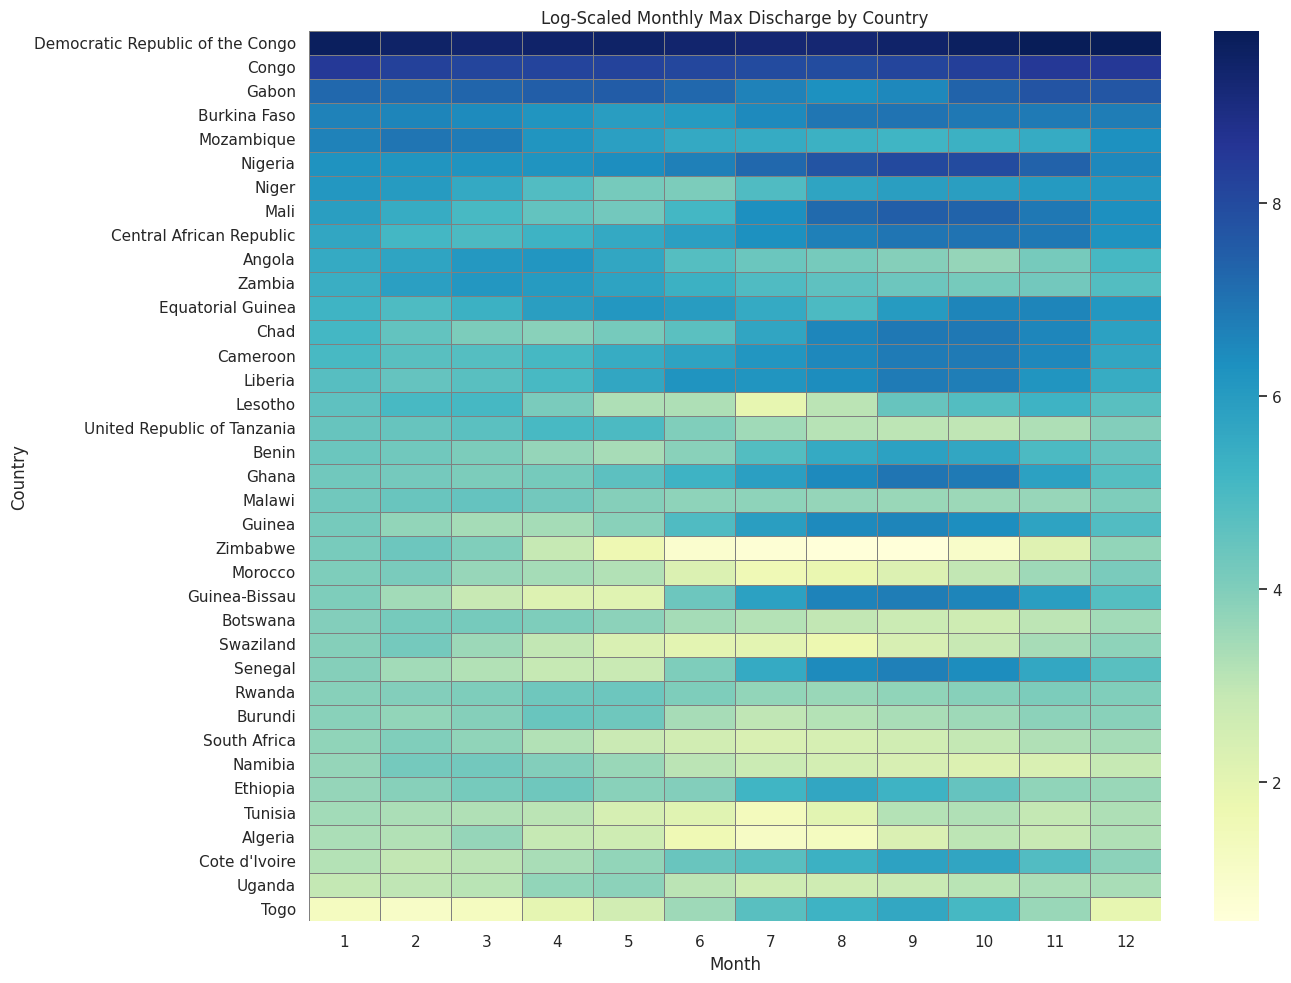

In [ ]:
import numpy as np

# Apply log(1 + Max_Q) to better visualize low vs high flows
seasonality_log = np.log1p(seasonality_pivot)

plt.figure(figsize=(14, 10))
sns.heatmap(seasonality_log, cmap="YlGnBu", linewidths=0.5, linecolor="gray")

plt.title("Log-Scaled Monthly Max Discharge by Country")
plt.xlabel("Month")
plt.ylabel("Country")
plt.tight_layout()
plt.show()


- Equatorial countries (like DRC, Congo, Gabon) show consistently high discharge all year — double rainy seasons are visible in some.

- Sahelian & North African countries (e.g., Niger, Mali, Morocco) show:

- Sharp flood peaks mid-year (around July–September), likely linked to the West African Monsoon.

- Southern Africa (e.g., Zimbabwe, South Africa, Botswana):

Tends to flood in January–March, aligning with the austral summer.

 Normalize per country (row-wise) to see peak month patterns

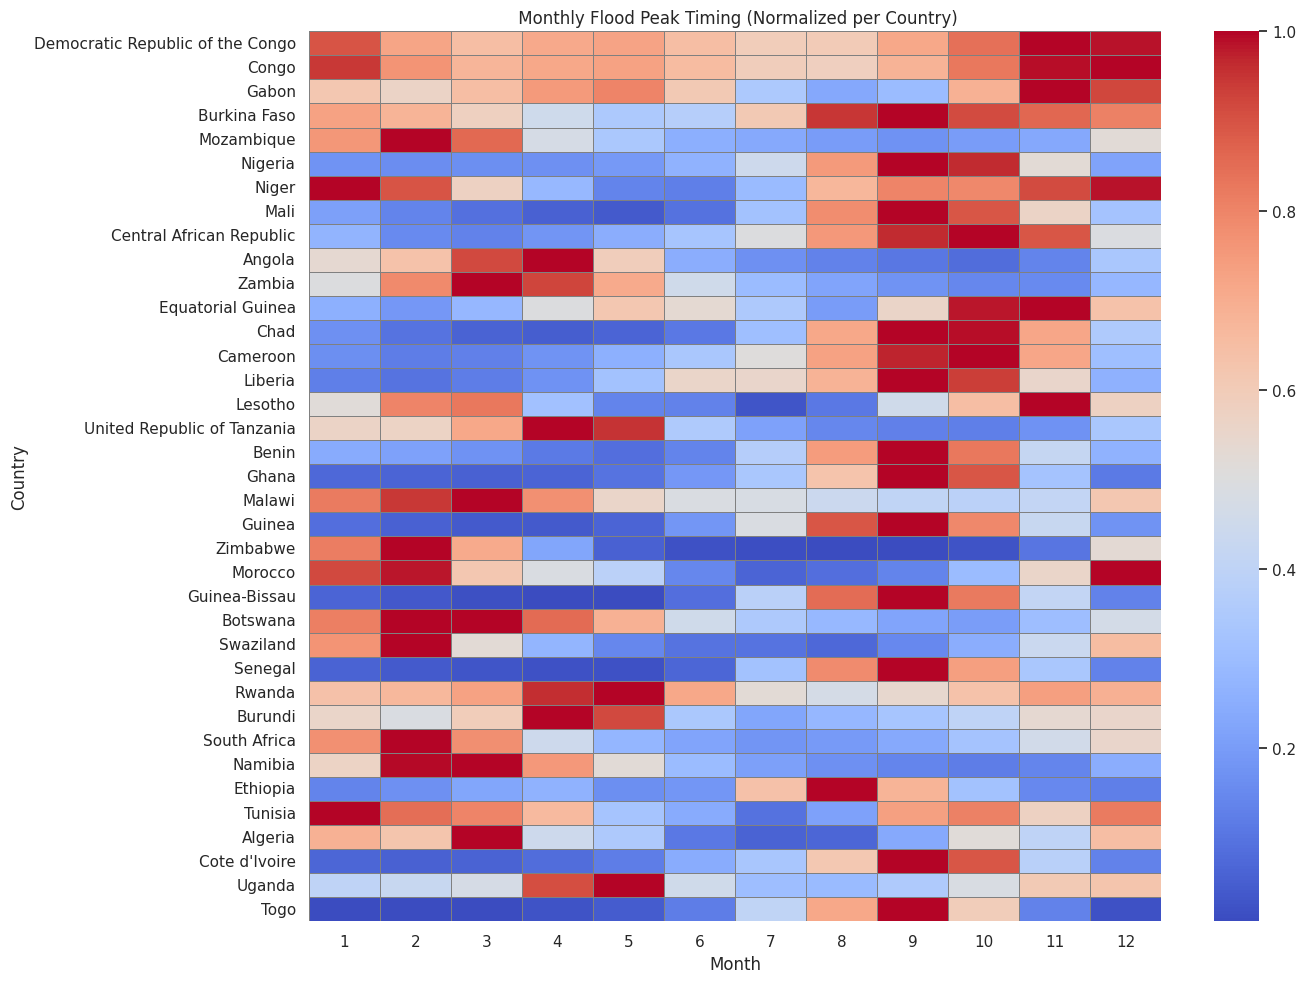

In [ ]:
# Normalize each row (country) to range 0–1
normalized = seasonality_pivot.div(seasonality_pivot.max(axis=1), axis=0)

plt.figure(figsize=(14, 10))
sns.heatmap(normalized, cmap="coolwarm", linewidths=0.5, linecolor="gray")

plt.title(" Monthly Flood Peak Timing (Normalized per Country)")
plt.xlabel("Month")
plt.ylabel("Country")
plt.tight_layout()
plt.show()


 Cluster Countries with Similar Flood Seasonality

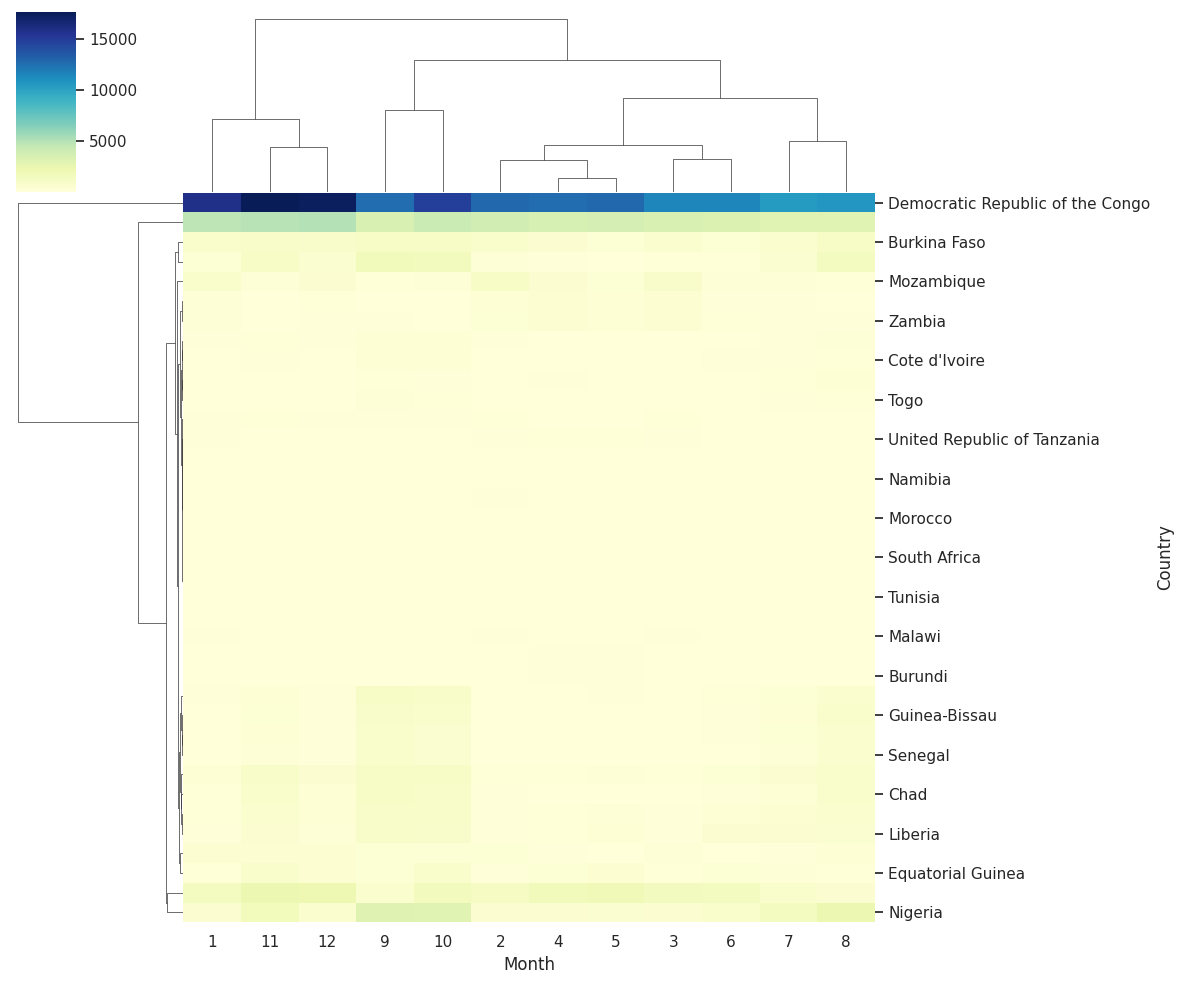

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Scale values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(seasonality_pivot.fillna(0))

# Cluster (e.g., 4 groups)
kmeans = KMeans(n_clusters=4, random_state=42)
seasonality_pivot["Cluster"] = kmeans.fit_predict(X_scaled)

# Visualize clustered countries
sns.clustermap(seasonality_pivot.drop("Cluster", axis=1), cmap="YlGnBu", metric="euclidean", figsize=(12, 10))


Ensure each station has sufficient monthly data before modeling

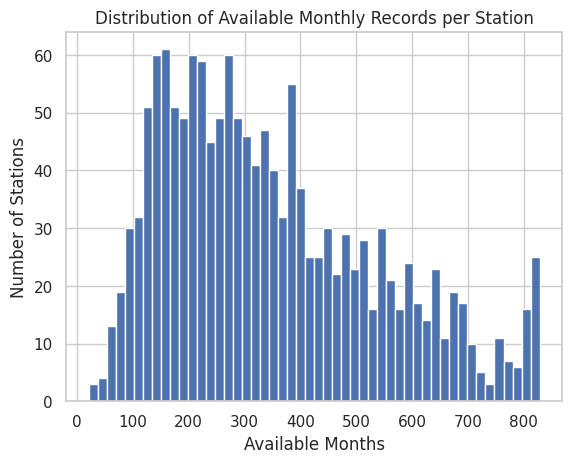

In [ ]:
# Create YearMonth column
monthly_df["YearMonth"] = monthly_df["Date"].dt.to_period("M")

# Count how many YearMonth entries per Station
monthly_counts = monthly_df.groupby(["Station_ID", "YearMonth"]).size().reset_index(name="Entries")

# Count how many months are available per station
station_coverage = monthly_counts.groupby("Station_ID")["Entries"].count().reset_index()
station_coverage.columns = ["Station_ID", "Available_Months"]

#  Plot coverage distribution
import matplotlib.pyplot as plt
station_coverage["Available_Months"].hist(bins=50)
plt.title("Distribution of Available Monthly Records per Station")
plt.xlabel("Available Months")
plt.ylabel("Number of Stations")
plt.grid(True)
plt.show()


In [ ]:
monthly_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510762 entries, 0 to 510761
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Year          510762 non-null  int32         
 1   Month         510762 non-null  int64         
 2   Mean_Q        510762 non-null  float64       
 3   Max_Q         510762 non-null  float64       
 4   Min_Q         510762 non-null  float64       
 5   Missing_days  510762 non-null  int64         
 6   Station_ID    510762 non-null  object        
 7   Date          510762 non-null  datetime64[ns]
 8   Country       510762 non-null  object        
 9   YearMonth     510762 non-null  period[M]     
 10  season_label  510762 non-null  object        
 11  Country_y     510762 non-null  object        
dtypes: datetime64[ns](1), float64(3), int32(1), int64(2), object(4), period[M](1)
memory usage: 44.8+ MB


Extract Peak Month as Label (for Classification)

In [ ]:
# Find the peak month each year per station
monthly_df["Year"] = monthly_df["Date"].dt.year
peak_months = monthly_df.loc[monthly_df.groupby(["Station_ID", "Year"])["Max_Q"].idxmax()]

# Drop rows with NaN peaks if any
peak_months = peak_months.dropna(subset=["Max_Q"])

# Rename for clarity
peak_months = peak_months[["Station_ID", "Year", "Month", "Max_Q"]]
peak_months = peak_months.rename(columns={"Month": "Peak_Month"})

# preview
peak_months.head()


,Station_ID,Year,Peak_Month,Max_Q
3,ADHI_1,1963,8,101.00
16,ADHI_1,1964,9,126.00
28,ADHI_1,1965,9,218.00
40,ADHI_1,1966,9,147.00
51,ADHI_1,1967,8,70.09


 Join with Static Features

In [ ]:
# Merge peak months with static station features
peak_features_df = pd.merge(peak_months, stations_df, left_on="Station_ID", right_on="ID", how="inner")
peak_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46579 entries, 0 to 46578
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Station_ID          46579 non-null  object 
 1   Year                46579 non-null  int32  
 2   Peak_Month          46579 non-null  int64  
 3   Max_Q               46579 non-null  float64
 4   ID                  46579 non-null  object 
 5   Station_co          46579 non-null  object 
 6   Name                46579 non-null  object 
 7   Data_sourc          46579 non-null  object 
 8   Catchment           46579 non-null  float64
 9   Mean_altit          46579 non-null  float64
 10  Maximum_al          46579 non-null  int64  
 11  Minimum_al          46579 non-null  int64  
 12  Mean_annual_precip  46579 non-null  float64
 13  Mean_annual_pet     46569 non-null  float64
 14  Mean_annual_temp    46579 non-null  float64
 15  lc_forest           46579 non-null  float64
 16  lc_u

 Train Classification Model to Predict Peak Month

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Prepare data
features = [
    "Catchment", "Mean_annual_temp", "Mean_annual_precip", "Mean_annual_pet",
    "lc_urban", "lc_crop", "lc_forest", "lc_bare",
    "Latitude", "Longitude", "Mean_altit", "Maximum_al", "Minimum_al"
]
X = peak_features_df[features]
y = peak_features_df["Peak_Month"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           1       0.25      0.31      0.28      1175
           2       0.24      0.34      0.28      1036
           3       0.27      0.26      0.27       893
           4       0.28      0.23      0.25       554
           5       0.26      0.18      0.22       292
           6       0.23      0.24      0.24       259
           7       0.20      0.10      0.13       332
           8       0.36      0.26      0.30       791
           9       0.50      0.67      0.57      1528
          10       0.49      0.32      0.39       922
          11       0.25      0.24      0.24       655
          12       0.22      0.15      0.17       879

    accuracy                           0.33      9316
   macro avg       0.30      0.27      0.28      9316
weighted avg       0.32      0.33      0.32      9316



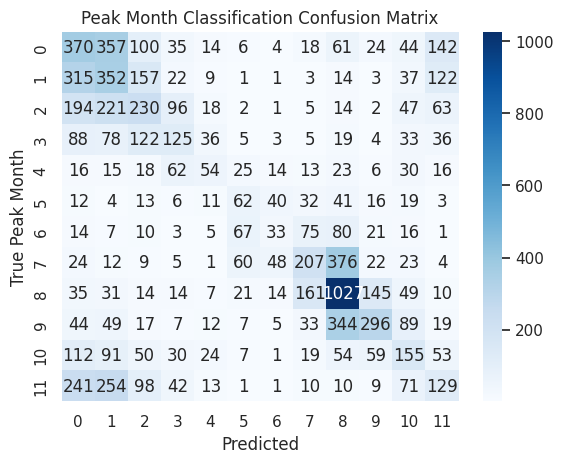

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True Peak Month")
plt.title("Peak Month Classification Confusion Matrix")
plt.show()


 Contextual Interpretation for Africa
The model highlights a real-world seasonal trend:

Most peak floods occur in late rainy season months (Jul–Oct), consistent with Africa’s rainfall patterns.

Poor performance in dry season months (Dec–Feb) is expected due to fewer flood events and lower data availability.

Classifying by Flood Season

In [ ]:
def month_to_season(month):
    if month in [12, 1, 2]:
        return "Dry"
    elif month in [3, 4, 5]:
        return "PreFlood"
    elif month in [6, 7, 8, 9]:
        return "Flood"
    else:  # Oct, Nov
        return "PostFlood"

peak_features_df["Peak_Season"] = peak_features_df["Peak_Month"].apply(month_to_season)


In [ ]:

# For season-level prediction (simpler)
y = peak_features_df["Peak_Season"]


In [ ]:
X = peak_features_df[features]

In [ ]:

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

              precision    recall  f1-score   support

         Dry       0.65      0.81      0.72      3090
       Flood       0.75      0.85      0.79      2910
   PostFlood       0.58      0.35      0.44      1577
    PreFlood       0.56      0.38      0.45      1739

    accuracy                           0.67      9316
   macro avg       0.64      0.60      0.60      9316
weighted avg       0.65      0.67      0.65      9316



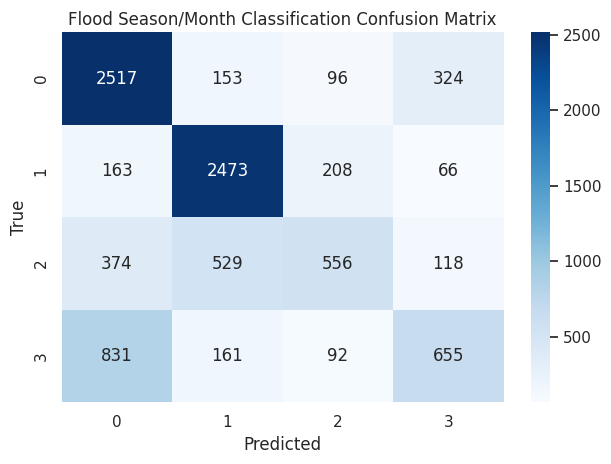

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Train
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

# Report
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Flood Season/Month Classification Confusion Matrix")
plt.tight_layout()
plt.show()


<ipython-input-84-0712d2534227>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df.head(15), x="Importance", y="Feature", palette="viridis")


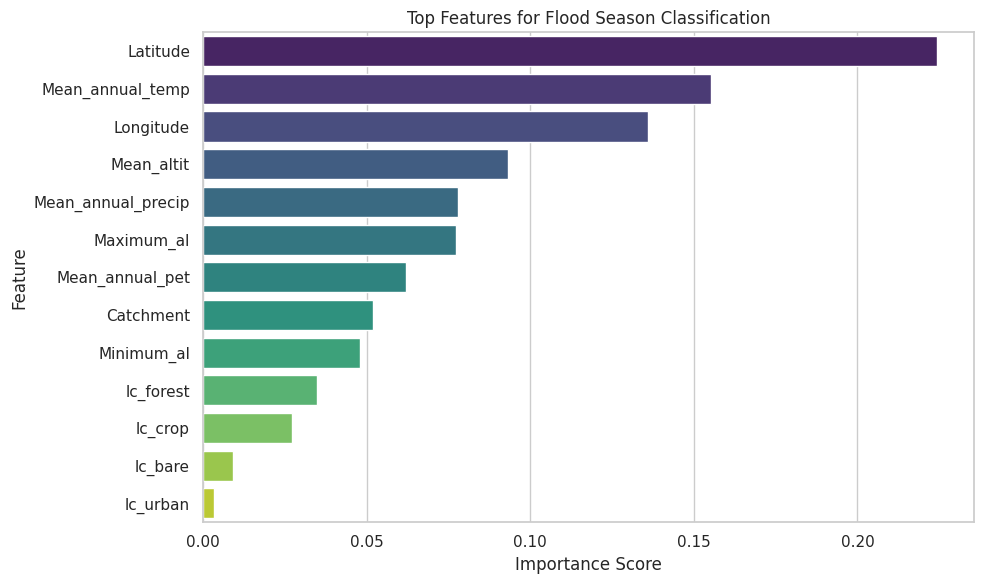

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances
importances = model.feature_importances_
feature_names = X.columns

# Create DataFrame for better visualization
importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df.head(15), x="Importance", y="Feature", palette="viridis")
plt.title("Top Features for Flood Season Classification")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


🔍 Classification Report (Balanced RF):
              precision    recall  f1-score   support

         Dry       0.69      0.69      0.69      3090
       Flood       0.80      0.78      0.79      2910
   PostFlood       0.46      0.50      0.48      1577
    PreFlood       0.48      0.48      0.48      1739

    accuracy                           0.64      9316
   macro avg       0.61      0.61      0.61      9316
weighted avg       0.65      0.64      0.65      9316



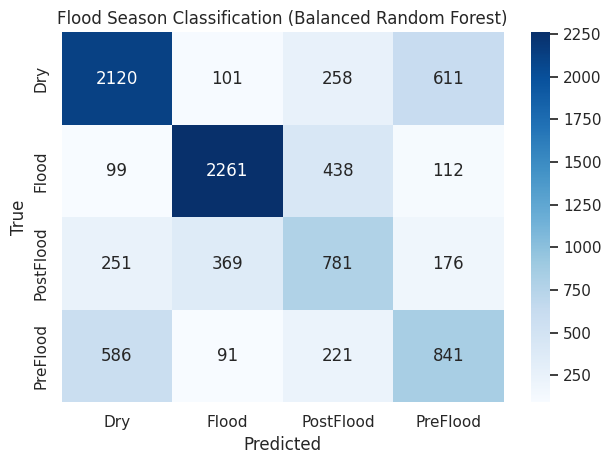

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 3: Train balanced random forest
clf = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
clf.fit(X_train, y_train)

# Step 4: Evaluation
y_pred = clf.predict(X_test)

# Classification Report
print("🔍 Classification Report (Balanced RF):")
print(classification_report(y_test, y_pred, target_names=["Dry", "Flood", "PostFlood", "PreFlood"]))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Dry", "Flood", "PostFlood", "PreFlood"], yticklabels=["Dry", "Flood", "PostFlood", "PreFlood"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Flood Season Classification (Balanced Random Forest)")
plt.tight_layout()
plt.show()


In [ ]:
# Example region mapping
country_to_region = {
    "Cameroon": "Central Africa",
    "Nigeria": "West Africa",
    "Mali": "West Africa",
    "Kenya": "East Africa",
    "Morocco": "North Africa",
    "South Africa": "Southern Africa",
    # Add the rest accordingly...
}

# Add region column
monthly_df["Region"] = monthly_df["Country"].map(country_to_region)


In [ ]:
regional_monthly = (
    monthly_df.groupby(["Region", "Month"])["Max_Q"]
    .mean()
    .reset_index()
)


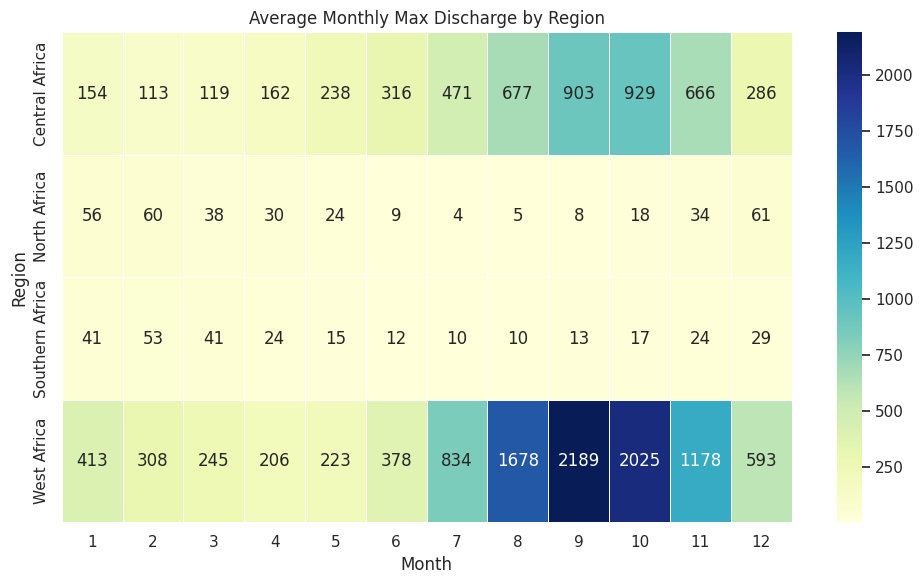

In [ ]:
pivot_region = regional_monthly.pivot(index="Region", columns="Month", values="Max_Q")
pivot_region = pivot_region.sort_index()

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_region, cmap="YlGnBu", linewidths=0.5, annot=True, fmt=".0f")
plt.title("Average Monthly Max Discharge by Region")
plt.xlabel("Month")
plt.ylabel("Region")
plt.tight_layout()
plt.show()


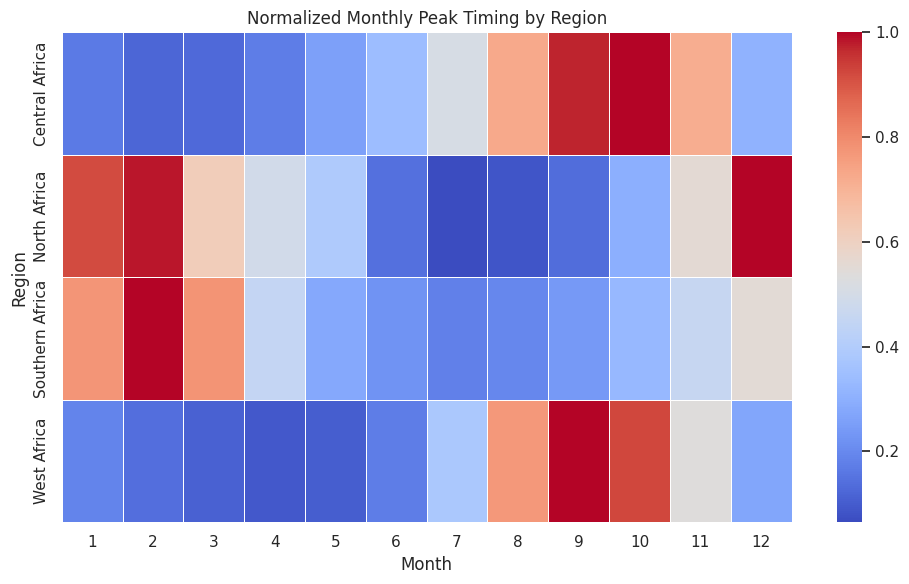

In [ ]:
pivot_region_normalized = pivot_region.div(pivot_region.max(axis=1), axis=0)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_region_normalized, cmap="coolwarm", linewidths=0.5)
plt.title("Normalized Monthly Peak Timing by Region")
plt.xlabel("Month")
plt.ylabel("Region")
plt.tight_layout()
plt.show()


In [ ]:
import joblib
# Save the season classification model
joblib.dump(model, "flood_season_classifier.pkl")

# Save the peak month classification model
joblib.dump(clf, "flood_month_classifier.pkl")

print("Models saved successfully!")

Models saved successfully!
